In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
import numpy as np
import re
from collections import defaultdict
from itertools import combinations
from collections import Counter
import math
import operator
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('Final_dataset.csv')
y = df['author_id'].unique()
l = []
for i in y:
    df1 = df[df['author_id']==i]
    l.append(min(df1['year']))
    
d = {
    'author_id':y,
    'first_paper':l
}
df1 = pd.DataFrame(d)
df1 = pd.merge(df1,df)
df1['paper_diff'] = df1['year'] -  df1['first_paper']
first3 = df1[df1['paper_diff']<3]
first5 = df1[df1['paper_diff']<5]

In [4]:
doc =[]
ver = []
with open('versionCod_DocCod.txt') as infile:
    for line in infile:
        a = line.split()
        ver.append(a[0])
        doc.append(a[1])
        
d = {'doc_id' : doc,
     'version' : ver}
ver_df = pd.DataFrame(d)

rev =[]
ver = []
with open('versionCod_refereeCod.txt') as infile:
    for line in infile:
        a = line.split()
        ver.append(a[0])
        rev.append(a[1])
        
d = {'reviewer' : rev,
     'version' : ver}
rev_df = pd.DataFrame(d)

df = pd.merge(ver_df,rev_df)
df = df[['doc_id','reviewer']]
df = df.drop_duplicates()
df.doc_id = df.doc_id.astype(int)
df.reviewer = df.reviewer.astype(int)
df = pd.merge(first3,df)
df = df[['doc_id','reviewer','author_id']]
df = df.drop_duplicates()

In [5]:
def p(n, N):
    if n is 0:
        return 0
    else:
        return (float(n)/N) * math.log(float(n)/N)

In [6]:
y = first3['author_id'].unique()
rev_div = []
for i in y:
    l = df[df['author_id']==i]['reviewer']
    if len(l)==0:
        rev_div.append(0)
        continue
    data = Counter(l)            
    N = sum(data.values())    
    rev_div.append(-sum(p(n, N) for n in data.values() if n is not 0))

In [7]:
d = {
    'author_id':y,
    'reviewer_diversity':rev_div
}

rev_div = pd.DataFrame(d)

In [8]:
cit = []
for i in y:
    l = first3[first3['author_id']==i]['citations']
    if len(l)==0:
        cit.append(0)
    else:
        cit.append(np.mean(l))
        
d = {
    'author_id':y,
    'citations':cit
}

cit = pd.DataFrame(d)

In [9]:
train = pd.merge(rev_div,cit)

In [10]:
sent = []
for i in y:
    l = first3[first3['author_id']==i]['Sentiment']
    if len(l)==0:
        sent.append(0)
    else:
        sent.append(np.mean(l))
        
d = {
    'author_id':y,
    'Sentiment':sent
}

sent = pd.DataFrame(d)

In [11]:
train = pd.merge(train,sent)

In [12]:
rounds = []
for i in y:
    l = first3[first3['author_id']==i]['rounds']
    if len(l)==0:
        rounds.append(0)
    else:
        rounds.append(np.mean(l))
        
d = {
    'author_id':y,
    'rounds':rounds
}

rounds = pd.DataFrame(d)

In [13]:
train = pd.merge(train,rounds)

In [14]:
exp = []
for i in y:
    l = first3[first3['author_id']==i].shape[0]
    exp.append(l)
        
d = {
    'author_id':y,
    'experience':exp
}

exp = pd.DataFrame(d)

In [15]:
train = pd.merge(train,exp)

In [16]:
doc =[]
ver = []
with open('versionCod_DocCod.txt') as infile:
    for line in infile:
        a = line.split()
        ver.append(a[0])
        doc.append(a[1])
        
d = {'doc_id' : doc,
     'version' : ver}
ver_df = pd.DataFrame(d)


edi =[]
ver = []
with open('versionCod_EditorCod.txt') as infile:
    for line in infile:
        a = line.split()
        ver.append(a[0])
        edi.append(a[1])
        
d = {'version' : ver,
     'editor' : edi}
edi_df = pd.DataFrame(d)


df = pd.merge(ver_df,edi_df)
df = df[['doc_id','editor']]
df = df.drop_duplicates()
df.doc_id = df.doc_id.astype(int)
df.editor = df.editor.astype(int)
df = pd.merge(first3,df)
df = df[['doc_id','editor','author_id']]
df = df.drop_duplicates()


In [17]:
edi_div = []
for i in y:
    l = df[df['author_id']==i]['editor']
    if len(l)==0:
        edi_div.append(0)
        continue
    data = Counter(l)            
    N = sum(data.values())    
    edi_div.append(-sum(p(n, N) for n in data.values() if n is not 0))
    
d = {
    'author_id':y,
    'editor_diversity':edi_div
}

edi_div = pd.DataFrame(d)

In [18]:
train = pd.merge(train,edi_div)

In [19]:
edge = []
with open('CoauthRefNetworkfirst3.txt') as infile:
    for line in infile:
        edge.append(line.split())
G = nx.Graph()

edges = [(k[0],k[1],{'weight':int(k[2])}) for k in edge]
G.add_edges_from(edges)

In [20]:
G.remove_edges_from(G.selfloop_edges())
core = nx.algorithms.core_number(G)

In [21]:
cn = []
for i in y:
    try:
        cn.append(core[str(i)])
    except:
        cn.append(0)
        
d = {
    'author_id':y,
    'core':cn
}

core = pd.DataFrame(d)

In [22]:
train = pd.merge(train,core)

In [23]:
l =[]
for i in y:
    a = sorted(first3[first3['author_id']==i]['citations'],reverse=True)
    if len(a)==0:
        l.append(0)
        continue
    j = 0
    for j in range(len(a)):
        if a[j]>=j:
            continue
        else:
            break
    l.append(j)
    
d = {
    'author_id':y,
    'h_index':l
}

h_index = pd.DataFrame(d)

In [24]:
train = pd.merge(train,h_index)

In [25]:
ts = []
for i in y:
    l = first3[first3['author_id']==i]['team_size']
    if len(l)==0:
        ts.append(0)
    else:
        ts.append(np.mean(l))
        
d = {
    'author_id':y,
    'team_size':ts
}

ts = pd.DataFrame(d)
train = pd.merge(train,ts)

In [26]:
degree_centrality = nx.degree_centrality(G)

In [27]:
deg = []
for i in y:
    try:
        deg.append(degree_centrality[str(i)])
    except:
        deg.append(0)
        
d = {
    'author_id':y,
    'degree_centrality':deg
}

deg = pd.DataFrame(d)

In [28]:
train = pd.merge(train,deg)

In [29]:
train.shape

(22828, 11)

In [30]:
train.dtypes

author_id             float64
reviewer_diversity    float64
citations             float64
Sentiment             float64
rounds                float64
experience              int64
editor_diversity      float64
core                    int64
h_index                 int64
team_size             float64
degree_centrality     float64
dtype: object

In [31]:
high = []
with open('high_acceptance.txt') as infile:
    for line in infile:
        a = line.split(':')
        high.append(int(a[0]))
low = []
with open('low_acceptance.txt') as infile:
    for line in infile:
        a = line.split(':')
        low.append(int(a[0]))
med = []
with open('medium_acceptance.txt') as infile:
    for line in infile:
        a = line.split(':')
        med.append(int(a[0]))
l = []
for i in y:
    if i in high:
        l.append(0)
    elif i in med:
        l.append(1)
    elif i in low:
        l.append(2)
    else:
        l.append(-1)
        
d = {
    'author_id':y,
    'Flag':l
}

flag = pd.DataFrame(d)
train = pd.merge(train,flag)

In [32]:
train.head()

,author_id,reviewer_diversity,citations,Sentiment,rounds,experience,editor_diversity,core,h_index,team_size,degree_centrality,Flag
0,13513.0,1.039721,45.600000,0.261923,1.400000,5,0.562335,27,4,3.200000,0.002023,0
1,21593.0,1.609438,5.142857,0.096623,2.000000,7,1.332179,21,4,2.857143,0.001715,0
2,4302.0,1.609438,36.285714,-0.560291,1.714286,7,0.500402,62,6,3.714286,0.005936,1
3,8587.0,2.079442,34.000000,0.110877,4.533333,15,1.351784,46,14,2.666667,0.006551,0
4,3937.0,1.791759,91.888889,-0.266325,1.666667,9,1.560710,67,8,2.000000,0.009805,0


In [33]:
train = train[train['Flag']!=-1]

In [34]:
pr = pd.read_csv('pagerankfirst3.csv')
pr.columns = ['author_id','pagerank']
d = dict(zip(pr['author_id'], pr['pagerank']))

l = []
for i in y:
    try:
        l.append(d[i])
    except:
        l.append(0)
        
d = {
    'author_id':y,
    'pagerank':l
}

pr = pd.DataFrame(d)
train = pd.merge(train,pr)

In [35]:
deg_cocit = pd.read_csv('degree_centrality_cocitation_first3.csv')
deg_cocit.columns = ['author_id','deg_cen_cocit']
d = dict(zip(deg_cocit['author_id'], deg_cocit['deg_cen_cocit']))

l = []
for i in y:
    try:
        l.append(d[i])
    except:
        l.append(0)
        
d = {
    'author_id':y,
    'deg_cen_cocit':l
}

deg_cocit = pd.DataFrame(d)

train = pd.merge(train,deg_cocit)

In [36]:
recip = pd.read_csv('reciprocityfirst3.csv')
recip.columns = ['author_id','reciprocity']

d = dict(zip(recip['author_id'], recip['reciprocity']))

l = []
for i in y:
    try:
        l.append(d[i])
    except:
        l.append(0)
        
d = {
    'author_id':y,
    'reciprocity':l
}

recip = pd.DataFrame(d)


train = pd.merge(train,recip)

In [37]:
train.shape

(21794, 15)

In [38]:
recip = pd.read_csv('betweenness_centrality_cocitfirst3.csv')
recip.columns = ['author_id','betweenness_centrality_cocit']

d = dict(zip(recip['author_id'], recip['betweenness_centrality_cocit']))

l = []
for i in y:
    try:
        l.append(d[i])
    except:
        l.append(0)
        
d = {
    'author_id':y,
    'betweenness_centrality_cocit':l
}

bc_coci = pd.DataFrame(d)


train = pd.merge(train,bc_coci)

In [39]:
recip = pd.read_csv('clustering_coeff_cocitfirst3.csv')
recip.columns = ['author_id','clustering_coeff_cocit']

d = dict(zip(recip['author_id'], recip['clustering_coeff_cocit']))

l = []
for i in y:
    try:
        l.append(d[i])
    except:
        l.append(0)
        
d = {
    'author_id':y,
    'clustering_coeff_cocit':l
}

cc_coci = pd.DataFrame(d)


train = pd.merge(train,cc_coci)

In [40]:
recip = pd.read_csv('closeness_centrality_cocitfirst3.csv')
recip.columns = ['author_id','closeness_centrality_cocit']

d = dict(zip(recip['author_id'], recip['closeness_centrality_cocit']))

l = []
for i in y:
    try:
        l.append(d[i])
    except:
        l.append(0)
        
d = {
    'author_id':y,
    'closeness_centrality_cocit':l
}

clc_coci = pd.DataFrame(d)


train = pd.merge(train,clc_coci)

In [41]:
recip = pd.read_csv('pagerankcocitfirst3.csv')
recip.columns = ['author_id','pagerankcocit']

d = dict(zip(recip['author_id'], recip['pagerankcocit']))

l = []
for i in y:
    try:
        l.append(d[i])
    except:
        l.append(0)
        
d = {
    'author_id':y,
    'pagerankcocit':l
}

pr_coci = pd.DataFrame(d)


train = pd.merge(train,pr_coci)

In [42]:
train.shape

(21794, 19)

In [43]:
train.head()

,author_id,reviewer_diversity,citations,Sentiment,rounds,experience,editor_diversity,core,h_index,team_size,degree_centrality,Flag,pagerank,deg_cen_cocit,reciprocity,betweenness_centrality_cocit,clustering_coeff_cocit,closeness_centrality_cocit,pagerankcocit
0,13513.0,1.039721,45.600000,0.261923,1.400000,5,0.562335,27,4,3.200000,0.002023,0,0.000048,0.013203,0.146552,0.000035,0.342857,0.260422,0.000058
1,21593.0,1.609438,5.142857,0.096623,2.000000,7,1.332179,21,4,2.857143,0.001715,0,0.000058,0.006146,0.222222,0.000000,0.000000,0.000000,0.000019
2,4302.0,1.609438,36.285714,-0.560291,1.714286,7,0.500402,62,6,3.714286,0.005936,1,0.000111,0.026576,0.256959,0.005663,0.178795,0.300457,0.000178
3,8587.0,2.079442,34.000000,0.110877,4.533333,15,1.351784,46,14,2.666667,0.006551,0,0.000137,0.020373,0.324022,0.000751,0.199405,0.275138,0.000178
4,3937.0,1.791759,91.888889,-0.266325,1.666667,9,1.560710,67,8,2.000000,0.009805,0,0.000170,0.025893,0.263736,0.001948,0.135690,0.286803,0.000317


In [44]:

X = train.drop(['author_id','Flag','rounds'],axis=1)
y = train['Flag']

In [2]:
import json
import lightgbm as lgb
import pandas as pd
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning:

numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.



In [45]:
from sklearn.metrics import f1_score

In [46]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=43,shuffle=True)


In [47]:
from sklearn.metrics import confusion_matrix

In [48]:
para ={
    'colsample_bytree': 0.9,
    'learning_rate': 0.12,
    'max_depth': 30,
    'min_child_weight': 3,
    'n_estimators': 1000,
    'n_jobs': -1,
    'objective': 'multi:softmax',
    'num_class':3,
    'seed': 1337,
    'silent': 0,
    'subsample': 0.9,
    'eval_metric' : 'map' ,
    
    }

In [49]:
X_tr , X_te , y_tr , y_te = train_test_split(X,y,test_size=0.2,random_state = 10)

In [50]:
dtrain = xgb.DMatrix(X_tr, label=y_tr)
dtest = xgb.DMatrix(X_te)
bst = xgb.train(para, dtrain,15)


In [51]:
pred = bst.predict(dtest)

In [52]:
cm = confusion_matrix(y_te, pred)

In [53]:
cm

array([[ 445,  231,   23],
       [  98, 1701,  185],
       [  19,  230, 1427]], dtype=int64)

In [54]:
recall = np.diag(cm).astype(float) / np.sum(cm, axis = 1)

In [55]:
recall

array([0.63662375, 0.85735887, 0.85143198])

In [56]:
precision = np.diag(cm).astype(float) / np.sum(cm, axis = 0)

In [57]:
precision

array([0.79181495, 0.78677151, 0.87278287])

In [58]:
test = pd.read_csv("Test_category.csv")

In [59]:
values = test['Flag']

In [60]:
test.drop(['author_id','Flag','rounds'],axis=1,inplace=True)

In [61]:
dtrain = xgb.DMatrix(X, label=y)
dtest = xgb.DMatrix(test)
bst = xgb.train(para, dtrain,15)


In [62]:
pred = bst.predict(dtest)

In [63]:
f1_score(values,pred,average='micro')

0.8629898137101955

In [64]:
cm = confusion_matrix(values, pred)
cm

array([[2569,  801,  144],
       [ 629, 8792,  465],
       [  34,  913, 7447]], dtype=int64)

In [65]:
recall = np.diag(cm).astype(float) / np.sum(cm, axis = 1)
recall

array([0.7310757 , 0.88933846, 0.88718132])

In [66]:
precision = np.diag(cm).astype(float) / np.sum(cm, axis = 0)
precision

array([0.79486386, 0.83685513, 0.92440417])

In [67]:
feature_imp = bst.get_score(importance_type='gain')

In [68]:
feature_imp = sorted(feature_imp.items(), key=operator.itemgetter(1),reverse=True)

In [69]:
from collections import OrderedDict

In [70]:
feature_imp = OrderedDict(feature_imp)

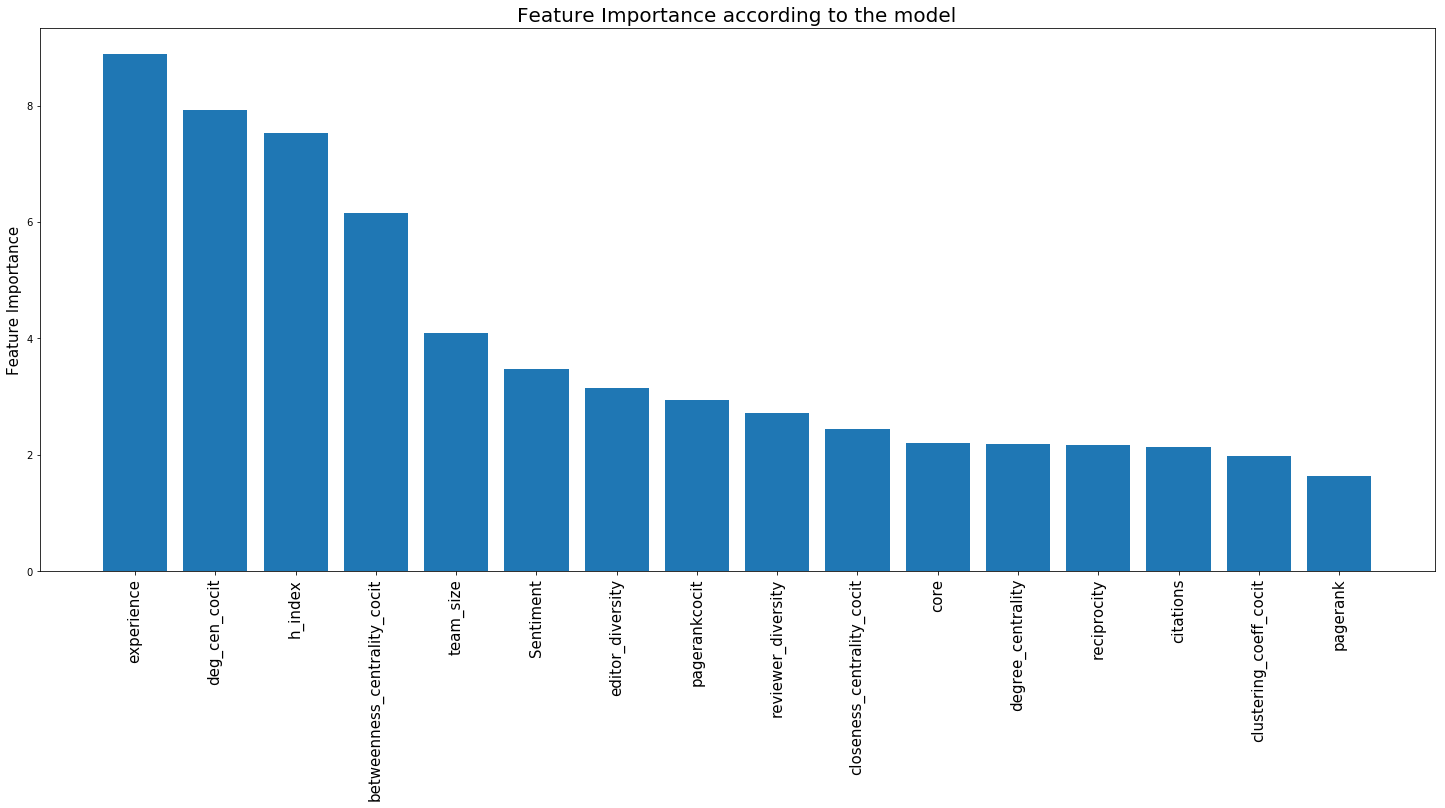

In [71]:
plt.figure(figsize=(25,10))
plt.bar(range(len(feature_imp)), feature_imp.values(), align='center')
plt.xticks(range(len(feature_imp)), list(feature_imp.keys()),fontsize = 15,rotation = 90)
plt.ylabel('Feature Importance',fontsize= 15)
plt.title('Feature Importance according to the model',fontsize= 20)

plt.show()

In [80]:
d = {
    'Features' : feature_imp.keys(),
    'Importance' : feature_imp.values()
}
df = pd.DataFrame(d)
df.to_csv('Feature_Importance_Xgb.csv',index=False)

In [53]:
from sklearn.ensemble import RandomForestClassifier

In [54]:
classifier = RandomForestClassifier(n_estimators = 100,max_depth=25,n_jobs=-1, criterion = 'entropy', random_state = 42)
classifier.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [60]:
y_pred = classifier.predict(test)

In [61]:
cm = confusion_matrix(values, y_pred)
cm

array([[2889,  527,   98],
       [ 604, 9006,  276],
       [  20,  727, 7647]], dtype=int64)

In [62]:
recall = np.diag(cm).astype(float) / np.sum(cm, axis = 1)
recall

array([0.82214001, 0.91098523, 0.91100786])

In [63]:
precision = np.diag(cm).astype(float) / np.sum(cm, axis = 0)
precision

array([0.82237404, 0.87777778, 0.9533724 ])

In [64]:
f1_score(values,y_pred,average='micro')

0.8966688079287877

In [65]:
d = dict(zip(X.columns, classifier.feature_importances_))

In [66]:
feature_imp = sorted(d.items(), key=operator.itemgetter(1),reverse=True)

In [67]:
feature_imp = pd.DataFrame(feature_imp)

In [68]:
feature_imp.to_csv('Feature_Importance.csv',index=False)

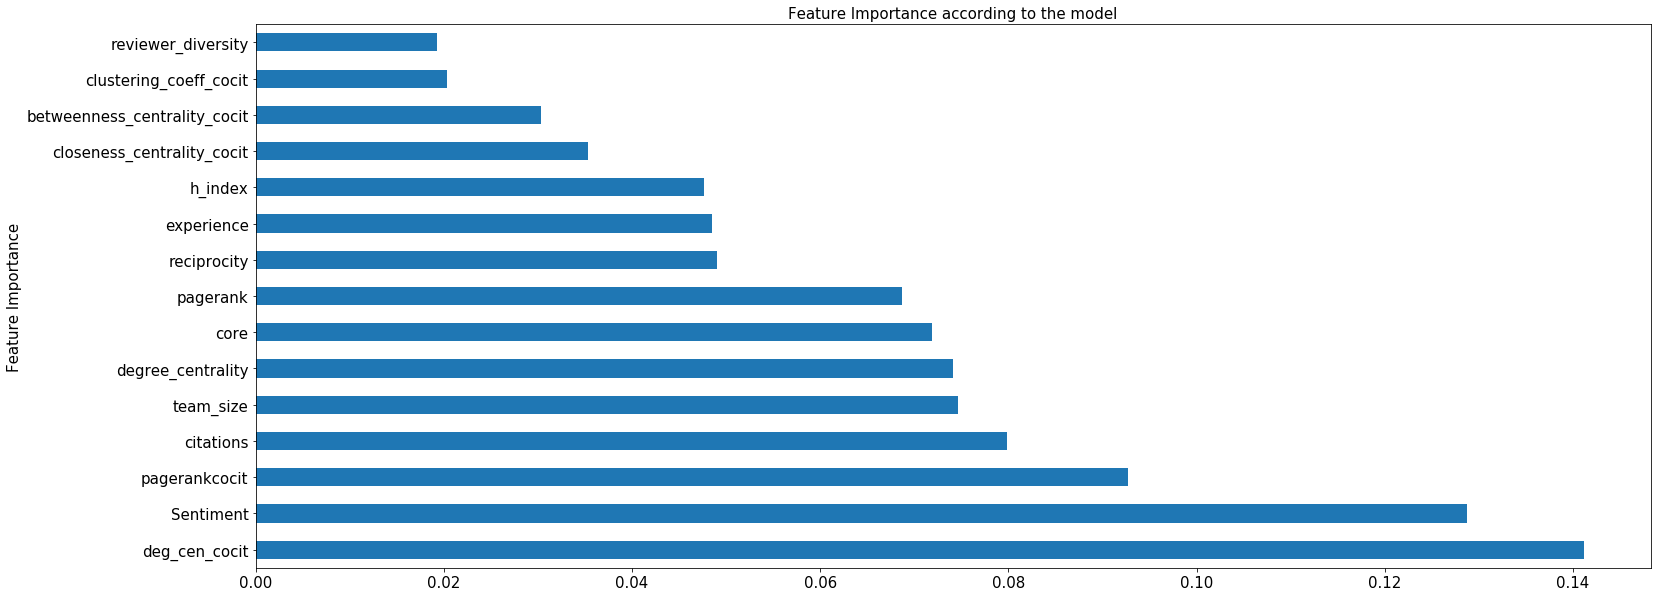

In [89]:
plt.figure(figsize=(25,10))
feat_importances = pd.Series(classifier.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh',fontsize=15)
plt.ylabel('Feature Importance',fontsize= 15)
plt.title('Feature Importance according to the model',fontsize= 15)

plt.show()